In [1]:
from astropy.table import Table, column, vstack
import astropy.units as u
import numpy as np

%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
# better-looking plots
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = (10.0, 8)
plt.rcParams['font.size'] = 18
mpl.ticker.AutoLocator.default_params['nbins'] = 5
mpl.ticker.AutoLocator.default_params['prune'] = 'both'

mpl.rcParams['ps.useafm'] = True
mpl.rcParams['pdf.use14corefonts'] = True
mpl.rcParams['text.usetex'] = True

import sys
sys.path.append('../astro_codes/')

In [2]:
s4g = Table.read('fits/s4g_halo_table_matched.fits')
sdss = Table.read('fits/sdss_halo_table_matched.fits')
sdss_w_gas = Table.read('fits/sdss_w_gas_table_matched.fits')

masks = Table.read('fits/masks.fits')

In [3]:
from astropy.nddata import NDDataArray as nda, StdDevUncertainty as sdu
from uncertainties import unumpy as unp

def unp_to_nda(data,unit=None):
    datas = [data[i].nominal_value for i in range(len(data))]
    uncertainties = [data[i].std_dev for i in range(len(data))]
    return nda(datas,sdu(uncertainties),unit=unit)  

def remove_negatives(column):
    column[column < 0] = 0
    return column

def add_f_columns(data,halo='hernquist'):
    
    data['delta_M_disc_total_2.2'] = remove_negatives(
                        data['delta_M_disc_total_2.2'])
    data['delta_M_bulge_2.2'] = remove_negatives(data['delta_M_bulge_2.2'])
    data['delta_M_halo_2.2_{}'.format(halo)] = remove_negatives(
                        data['delta_M_halo_2.2_{}'.format(halo)])
    
    M_disc = unp.uarray(data['M_disc_total_2.2'],
                        data['delta_M_disc_total_2.2'])
    
    M_bulge = unp.uarray(data['M_bulge_2.2'],data['delta_M_bulge_2.2'])
    M_halo = unp.uarray(data['M_halo_2.2_{}'.format(halo)],
                        data['delta_M_halo_2.2_{}'.format(halo)])
    
    M_tot = M_disc + M_bulge + M_halo
    f_disc = unp_to_nda(M_disc / M_tot)
    f_bulge = unp_to_nda(M_bulge / M_tot)
    f_halo = unp_to_nda(M_halo / M_tot)
    data['f_disc_{}'.format(halo)] = f_disc.data
    data['delta_f_disc_{}'.format(halo)] = f_disc.uncertainty.array
    data['f_bulge_{}'.format(halo)] = f_bulge.data
    data['delta_f_bulge_{}'.format(halo)] = f_bulge.uncertainty.array
    data['f_halo_{}'.format(halo)] = f_halo.data
    data['delta_f_halo_{}'.format(halo)] = f_halo.uncertainty.array
    return data

# Note: this _does_ work, it just takes a minute or two...
s4g = add_f_columns(s4g,'hernquist')
s4g = add_f_columns(s4g,'burkert')
sdss = add_f_columns(sdss,'hernquist')
sdss = add_f_columns(sdss,'burkert')
sdss_w_gas = add_f_columns(sdss_w_gas,'hernquist')
sdss_w_gas = add_f_columns(sdss_w_gas,'burkert')

In [89]:
class HistogramPlotter():
    def __init__(self):
        self.colnames = ['M_disc_total','R_disc_total',
                         'f_disc_hernquist','f_disc_burkert',
                         'M_bulge','R_bulge',
                         'f_bulge_hernquist','f_bulge_burkert',
                         'M_halo','R_halo',
                         'f_halo_hernquist','f_halo_burkert']
    
        self.error_colnames = ['delta_' + c for c in self.colnames]
        
        self.logs = [True, False, False, False,
                     True, False, False, False,
                     True, False, False, False]
        
        self.bins = [np.linspace(8.5,11.5,21),np.linspace(0,5,21),
                     np.linspace(0,1,21),np.linspace(0,1,21),
                     np.linspace(8.5,11.5,21),np.linspace(0,2,21),
                     np.linspace(0,1,21),np.linspace(0,1,21),
                     np.linspace(10.5,13.5,21),np.linspace(0,50,21),
                     np.linspace(0,1,21),np.linspace(0,1,21)]
        
    
    def make_figure(self):
        
        xlabels = ['$\log(M_\mathrm{d}/M_\odot)$','$R_\mathrm{d}$ [kpc]',
                   '$f_\mathrm{d}$ [$2.2R_\mathrm{d}$, Hernquist]',
                   '$f_\mathrm{d}$ [$2.2R_\mathrm{d}$, Burkert]',
                   '$\log(M_\mathrm{b}/M_\odot)$','$R_\mathrm{b}$ [kpc]',
                   '$f_\mathrm{b}$ [$2.2R_\mathrm{b}$, Hernquist]',
                   '$f_\mathrm{b}$ [$2.2R_\mathrm{b}$, Burkert]',
                   '$\log(M_\mathrm{h}/M_\odot)$','$R_\mathrm{h}$ [kpc]',
                   '$f_\mathrm{h}$ [$2.2R_\mathrm{d}$, Hernquist]',
                   '$f_\mathrm{h}$ [$2.2R_\mathrm{d}$, Burkert]']
        
        letters = 'abcdefghijklmnopqrstuvwxyz'
        
        fig, axarr = plt.subplots(3,4,figsize=(20,3*20/4))
        axarr = axarr.ravel()
        self.fig = fig
        self.axarr = axarr
        for ax, xlabel, letter, bin_ in zip(axarr,xlabels,letters,self.bins):
            _ = ax.set_xlabel(xlabel)
            _ = ax.text(0.05,0.95,'({})'.format(letter),
                        transform=ax.transAxes,va='top',ha='left',zorder=10)
            _ = ax.set_xlim(bin_[0],bin_[-1])
        
        #_ = fig.text(0, 0.5, 'normalised density', 
                     #ha='center', va='center', rotation='vertical')
        
        return self.fig, self.axarr

    def plot_histograms(self,data,median_line=True,
                        color='k',linestyle='solid',lw=2,**kwargs):
    
        for ax, colname, log, bin_ in zip(self.axarr,self.colnames,
                                          self.logs,self.bins):
            
            plt.sca(ax)
        
            x = data[colname] if log is False else np.log10(data[colname])
            is_finite = np.isfinite(x)
            x[is_finite == False] = bin_[0] # set to the lowest value...
            
            _ = ax.hist(x[is_finite],bin_,normed=True,
                        color=color,linestyle=linestyle,lw=lw,**kwargs)
            
            if median_line is True:
                median_value = np.median(x)
                plt.axvline(median_value,color=color,linestyle=linestyle,
                            lw=lw)
        return None
    
    def plot_errors(self,data,error_position=(0.9,0.9),**kwargs):
        for ax, colname, errorname, log in zip(self.axarr,self.colnames,
                                            self.error_colnames,self.logs):
            
            x = data[colname] if log is False else np.log10(data[colname])
            delta_x = (data[errorname] if log is False 
                       else np.log10(data[errorname]))
            is_finite = np.isfinite(x)
            if log is False:
                error = np.median(delta_x[is_finite])
            else:
                frac_errors = 10**delta_x[is_finite] / 10**x[is_finite]
                error = 0.434*np.median(frac_errors)
                
            x0, x1 = ax.get_xlim()
            y0, y1 = ax.get_ylim()
            if error_position[0] > 0.5:
                x_c = x0 + (x1-x0)*error_position[0] - error/2
            else:
                x_c = x0 + (x1-x0)*error_position[0] + error/2
            y_c = y0 + (y1-y0)*error_position[1]
            _ = ax.errorbar(x_c,y_c,xerr=error/2,**kwargs)
            
        return None
    
    def print_median_and_error(self,data,label='S4G'):
        print('--- {} ---'.format(label))
        for colname, log_ in zip(self.colnames,self.logs):
            x = data[colname]
            if log_ is True:
                x = np.log10(x)
            median_value = np.median(x)
            lower_percentile = np.percentile(x,16)
            upper_percentile = np.percentile(x,84)
            upper_error = upper_percentile - median_value
            lower_error = median_value - lower_percentile
            print('{}: {} + {} - {}'.format(colname,
             *np.round([median_value,lower_error,upper_error],decimals=2)))
        print('-------- \n')

/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in log10
/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:78: RuntimeWarning: divide by zero encountered in log10
/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:80: RuntimeWarning: divide by zero encountered in log10


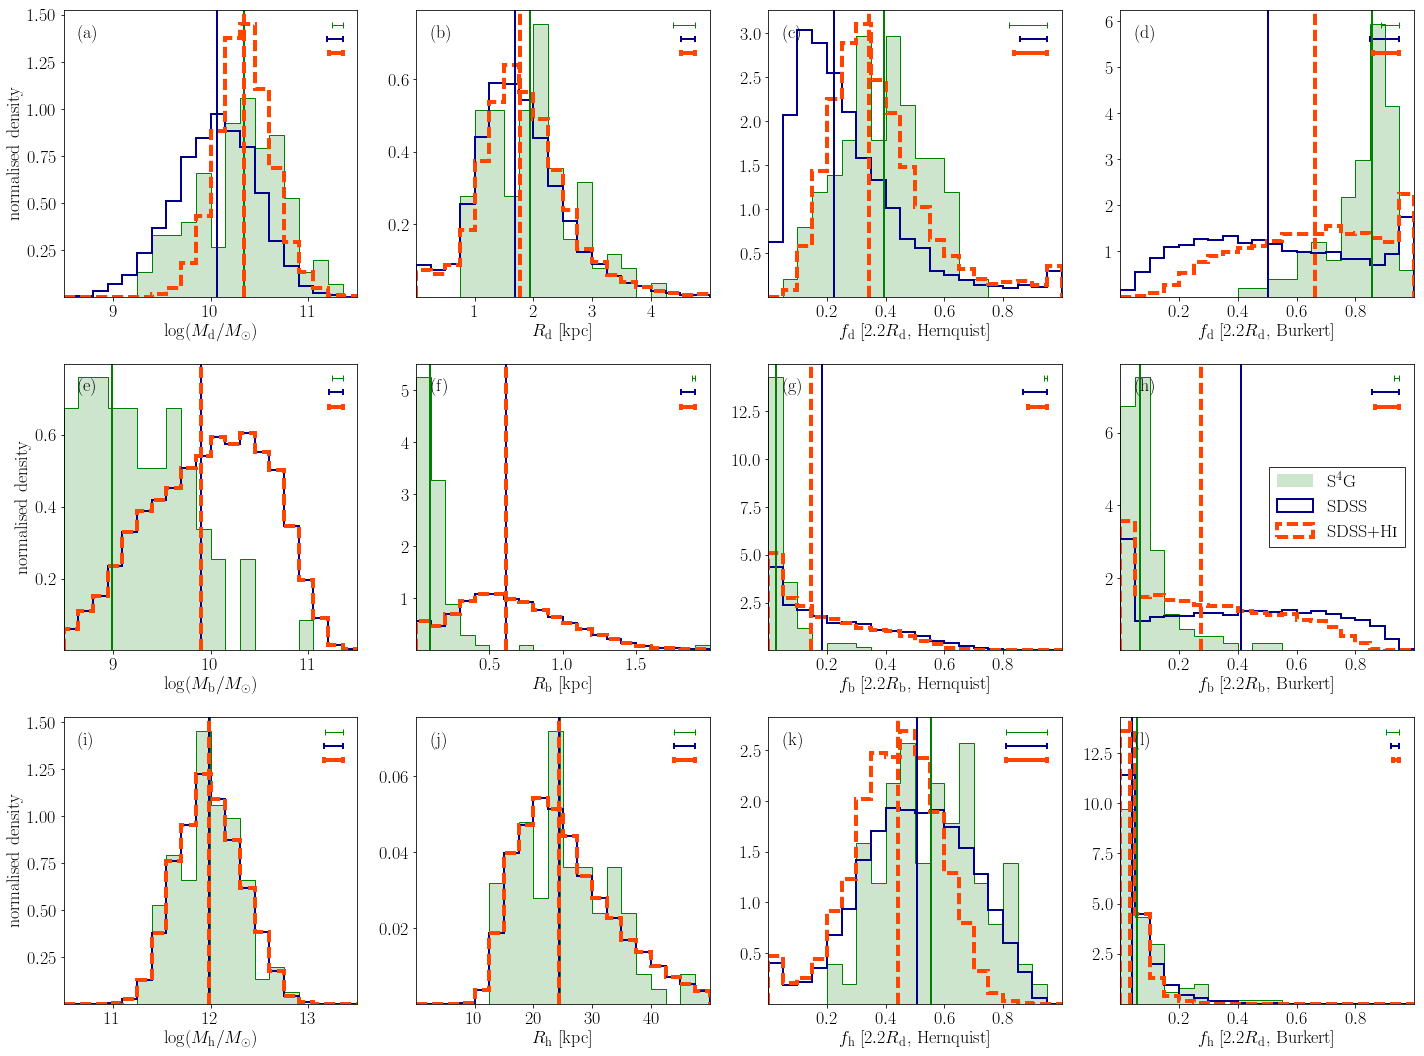

In [90]:
in_s4g = s4g['unbarred_sample']
in_sdss = masks['z<0.085 (+HI)']

h = HistogramPlotter()
fig, axarr = h.make_figure()

######## histograms #################
_ = h.plot_histograms(s4g[in_s4g],color='g',alpha=0.2,histtype='stepfilled',
                      label='S$^4$G')
_ = h.plot_histograms(s4g[in_s4g],color='g',lw=1,histtype='step',
                      median_line=False,label='_nolegend_')
_ = h.plot_histograms(sdss[in_sdss],color='darkblue',lw=2,
                      linestyle='solid',histtype='step',label='SDSS')
_ = h.plot_histograms(sdss_w_gas[in_sdss],color='orangered',lw=4,
                      linestyle='dashed',histtype='step',
                      label=r'SDSS+H\textsc{i}')
######### error lines ################
_ = h.plot_errors(s4g[in_s4g],(0.95,0.95),
                  color='g',lw=1,capthick=1,capsize=3)
_ = h.plot_errors(sdss[in_sdss],(0.95,0.9),
        lw=2,capthick=2,capsize=3,linestyle='solid',color='darkblue')
_ = h.plot_errors(sdss_w_gas[in_sdss],(0.95,0.85),
        color='orangered',linestyle='dashed',lw=4,capsize=3,capthick=4)

for a in [0,4,8]:
    _ = axarr[a].set_ylabel('normalised density')
    
_ = axarr[7].legend(loc='center right',
                    fancybox=False,edgecolor='k')

h.fig.tight_layout()
#h.fig.savefig('figures/all_distributions.pdf')

In [91]:
h.print_median_and_error(s4g[in_s4g],'s4g')
h.print_median_and_error(sdss[in_sdss],'sdss')
h.print_median_and_error(sdss_w_gas[in_sdss],'sdss+hi')
#h.print


--- s4g ---
M_disc_total: 10.34 + 0.54 - 0.38
R_disc_total: 1.94 + 0.71 - 0.79
f_disc_hernquist: 0.39 + 0.15 - 0.14
f_disc_burkert: 0.86 + 0.16 - 0.06
M_bulge: 8.99 + 0.64 - 0.76
R_bulge: 0.1 + 0.05 - 0.09
f_bulge_hernquist: 0.03 + 0.02 - 0.06
f_bulge_burkert: 0.07 + 0.04 - 0.07
M_halo: 11.99 + 0.37 - 0.3
R_halo: 24.59 + 7.64 - 8.64
f_halo_hernquist: 0.56 + 0.16 - 0.18
f_halo_burkert: 0.06 + 0.04 - 0.09
-------- 

--- sdss ---
M_disc_total: 10.07 + 0.44 - 0.39
R_disc_total: 1.69 + 0.62 - 0.77
f_disc_hernquist: 0.22 + 0.12 - 0.21
f_disc_burkert: 0.5 + 0.27 - 0.36
M_bulge: 9.9 + 1.04 - 0.68
R_bulge: 0.62 + 0.33 - 0.43
f_bulge_hernquist: 0.18 + 0.16 - 0.26
f_bulge_burkert: 0.41 + 0.35 - 0.32
M_halo: 11.98 + 0.32 - 0.35
R_halo: 24.35 + 6.69 - 10.36
f_halo_hernquist: 0.51 + 0.19 - 0.19
f_halo_burkert: 0.04 + 0.03 - 0.08
-------- 

--- sdss+hi ---
M_disc_total: 10.34 + 0.27 - 0.28
R_disc_total: 1.77 + 0.61 - 0.73
f_disc_hernquist: 0.34 + 0.12 - 0.18
f_disc_burkert: 0.66 + 0.28 - 0.25
M_bulge

/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:104: RuntimeWarning: divide by zero encountered in log10
